In [1]:
import sys
sys.path.append('../../ABEL/')
from abel import *

%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import matplotlib.pyplot as plt

In [18]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 11 # [m]
stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = True
stage.save_evolution = True
if stage.enable_radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 7500e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.01
source.bunch_length = 10e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 80e-6, 80e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
#beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1
shots = 1
num_jitter_values = 8
jitter_values = np.logspace(-7,-5.6,num_jitter_values)
print(jitter_values)

[1.00000000e-07 1.58489319e-07 2.51188643e-07 3.98107171e-07
 6.30957344e-07 1.00000000e-06 1.58489319e-06 2.51188643e-06]


In [19]:
# scan the driver timing jitter
linac.scan(f'scan_jitter_with_RR_{stage.enable_radiation_reaction}', 
           lambda obj, val: setattr(obj.stage.driver_source.jitter, 'x', val) or setattr(obj.stage.driver_source.jitter, 'y', val) or obj, 
           jitter_values,
           label='Driver jitter [$\mu m$]',
           scale=1e-6,
           num_shots_per_step=50, 
           parallel=False,
           overwrite=False);

>> SHOT 1 already exists and will not be overwritten.
>> SHOT 2 already exists and will not be overwritten.
>> SHOT 3 already exists and will not be overwritten.
>> SHOT 4 already exists and will not be overwritten.
>> SHOT 5 already exists and will not be overwritten.
>> SHOT 6 already exists and will not be overwritten.
>> SHOT 7 already exists and will not be overwritten.
>> SHOT 8 already exists and will not be overwritten.
>> SHOT 9 already exists and will not be overwritten.
>> SHOT 10 already exists and will not be overwritten.
>> SHOT 11 already exists and will not be overwritten.
>> SHOT 12 already exists and will not be overwritten.
>> SHOT 13 already exists and will not be overwritten.
>> SHOT 14 already exists and will not be overwritten.
>> SHOT 15 already exists and will not be overwritten.
>> SHOT 16 already exists and will not be overwritten.
>> SHOT 17 already exists and will not be overwritten.
>> SHOT 18 already exists and will not be overwritten.
>> SHOT 19 already 

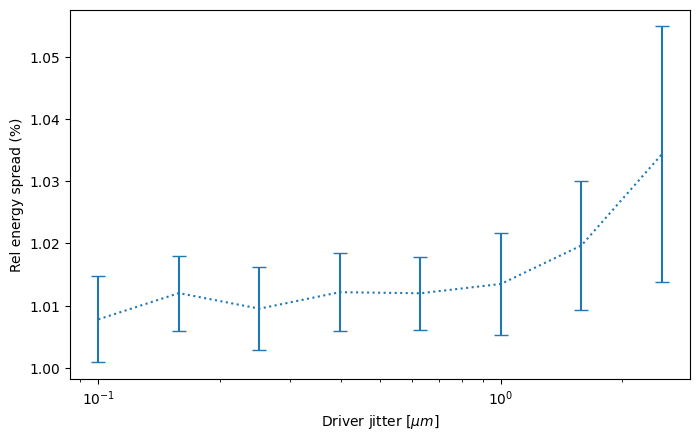

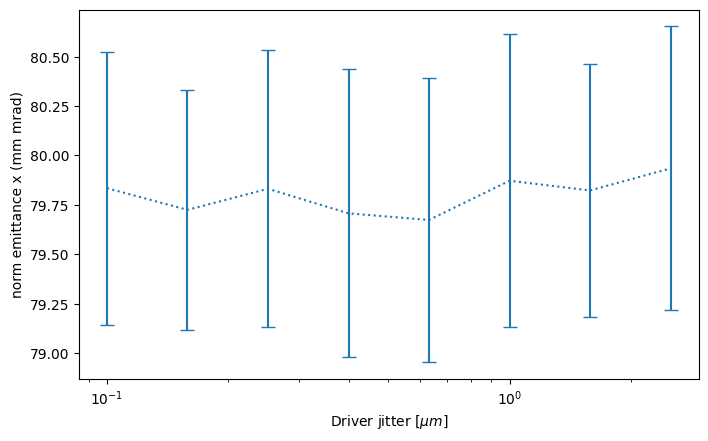

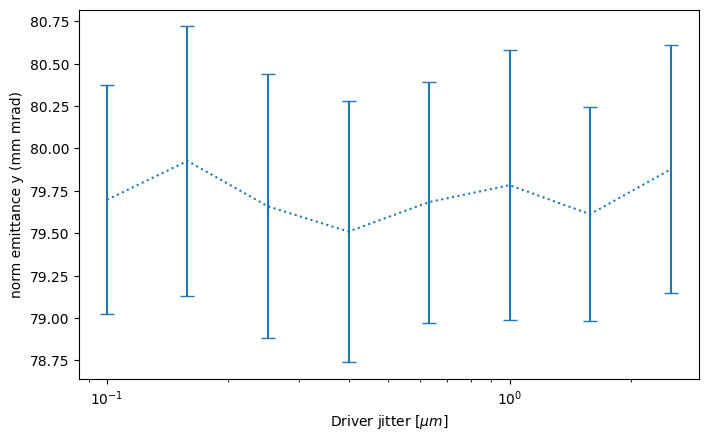

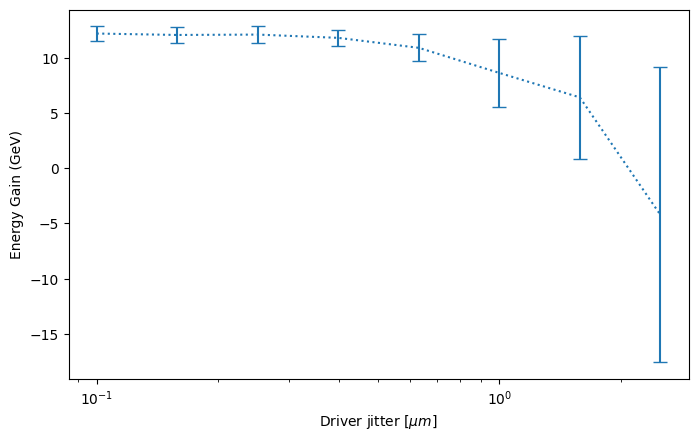

In [5]:
linac.plot_beam_function(Beam.rel_energy_spread, label='Rel energy spread (%)', scale=1e-2, xscale='log')
linac.plot_beam_function(Beam.norm_emittance_x, label='norm emittance x (mm mrad)', scale=1e-6, xscale='log')
linac.plot_beam_function(Beam.norm_emittance_y, label='norm emittance y (mm mrad)', scale=1e-6, xscale='log')
linac.plot_beam_function(lambda obj:obj.energy() - source.energy, label='Energy Gain (GeV)', scale=1e9, xscale='log')

In [27]:
list_of_E_ararys = [ [] for _ in range(num_jitter_values)]
print(list_of_E_ararys)
for j in range(num_jitter_values):
    Es = [linac[j,i].get_beam(-1).energy()/1e9 for i in range(linac.num_shots_per_step)]
    list_of_E_ararys[j] = Es

[[], [], [], [], [], [], [], []]


<Figure size 640x480 with 0 Axes>

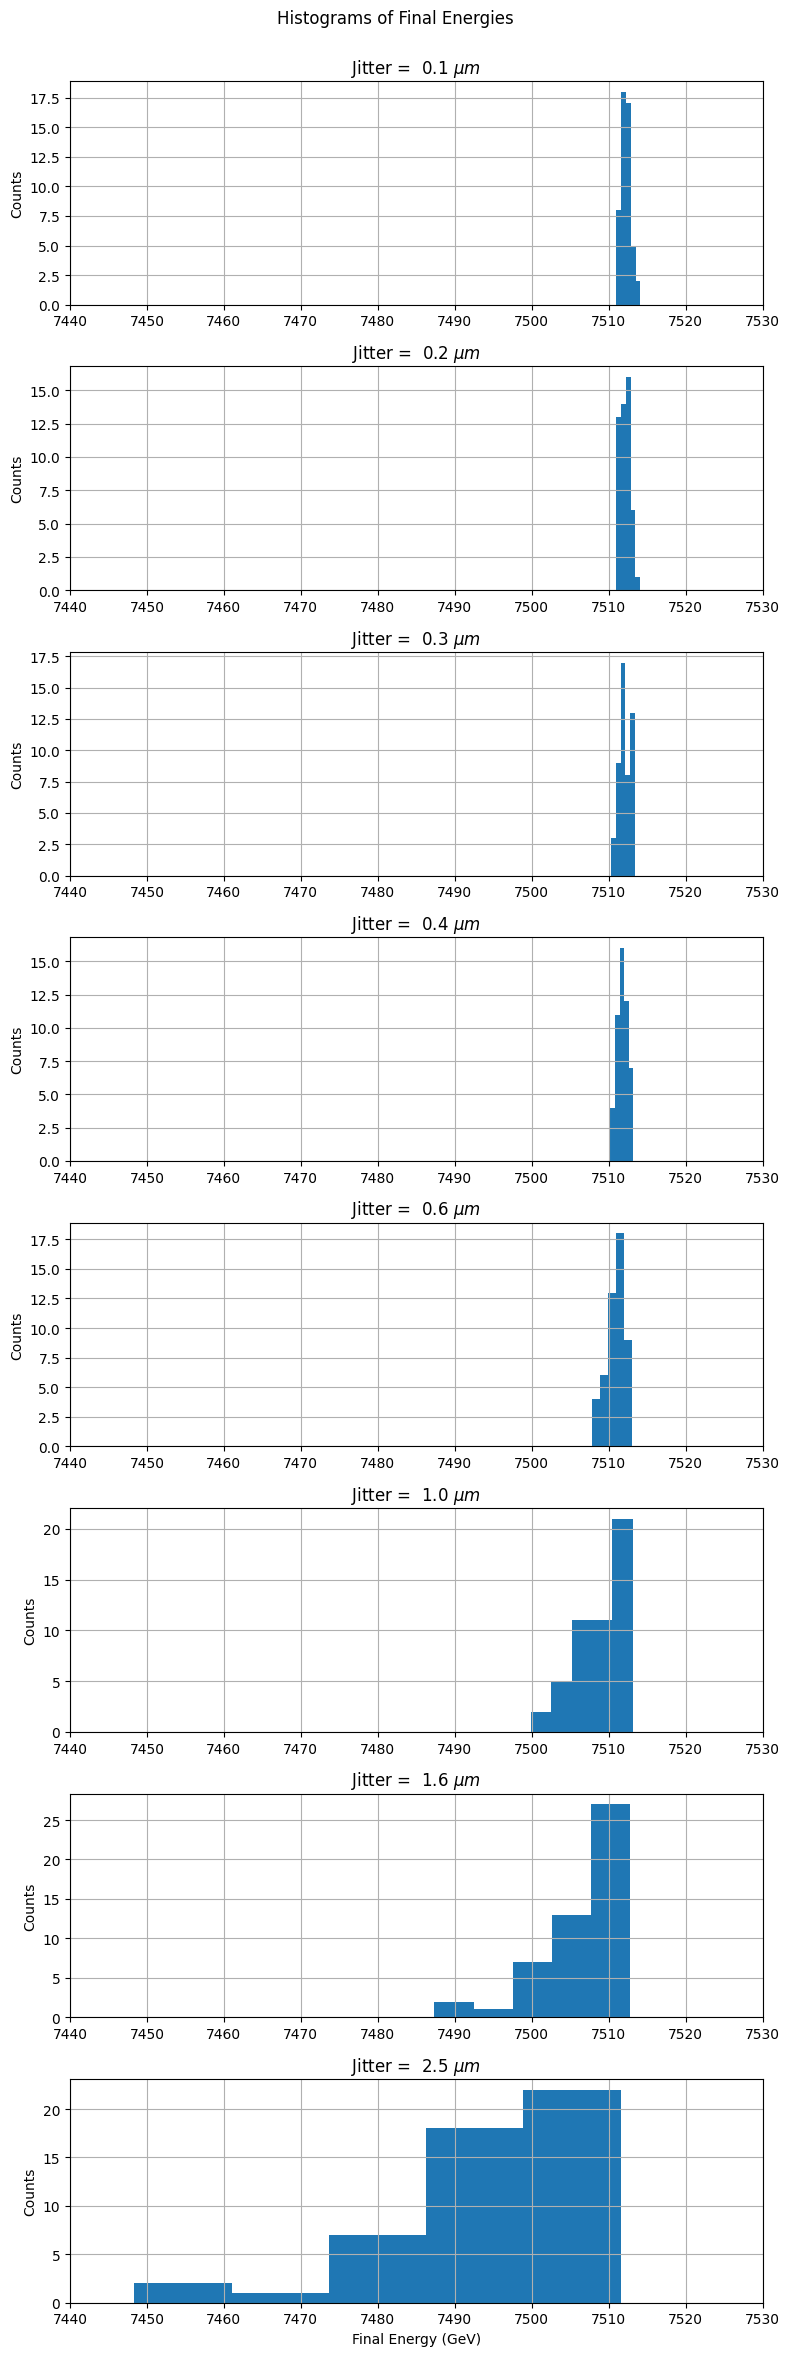

In [38]:
plt.subplots_adjust(hspace=0.4)
fig, axs = plt.subplots(8,1, figsize = (8,24))
fig.suptitle('Histograms of Final Energies')
for j, ax in enumerate(axs):
    ax.hist(list_of_E_ararys[j], bins =5)
    ax.set_title(f'Jitter = {jitter_values[j]*1e6: .1f} $\mu m$')
    ax.set_xlim([7440,7530])
    ax.set_ylabel('Counts')
    ax.grid()
axs[-1].set_xlabel('Final Energy (GeV)')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

fig.savefig('Plots/Jitter/final_energy_histograms', bbox_inches = 'tight')